In [1]:
# Script copied from https://thecleverprogrammer.com/2020/06/25/image-processing-with-machine-learning-and-python/

import numpy as np
from sklearn.datasets import fetch_lfw_people
from skimage import data, color, transform, feature
faces = fetch_lfw_people()
positive_patches = faces.images
print(positive_patches.shape)

(13233, 62, 47)


In [2]:
from skimage import data, transform
imgs_to_use = ['camera', 'text', 'coins', 'moon',
                      'page', 'clock', 'immunohistochemistry',
                      'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

<ipython-input-2-77b4d25ca56c>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


In [3]:
from sklearn.feature_extraction.image import PatchExtractor
def extract_patches(img, N, scale=1.0,
                    patch_size=positive_patches[0].shape):
    extracted_patch_size = \
        tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches
negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
print(negative_patches.shape)

(30000, 62, 47)


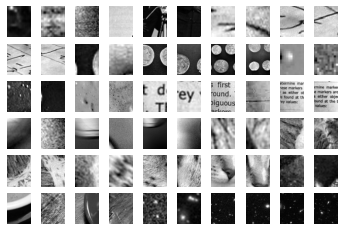

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')
plt.show()

In [5]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1
print(X_train.shape)

(43233, 1215)


In [6]:
from sklearn.naive_bayes import GaussianNB       
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), X_train, y_train)

array([0.94772754, 0.97189777, 0.97236036, 0.97490169, 0.97374508])

In [7]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/Users/baskausj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/baskausj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/baskausj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/baskausj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/baskausj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: Converge

0.9884578497284486

In [8]:
grid.best_params_

{'C': 1.0}

In [9]:
model = grid.best_estimator_        
model.fit(X_train, y_train)
#Output

LinearSVC()

In [20]:
import skimage
from skimage import io
import os
os.chdir('/Users/baskausj/ml_images')
print(os.getcwd())


/Users/baskausj/ml_images


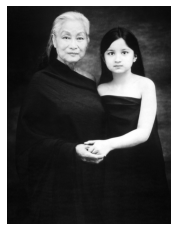

In [25]:
#test_image = skimage.data.astronaut()
test_image = io.imread('2015.044.tif', plugin='pil')
test_image = skimage.color.rgb2gray(test_image)        
test_image = skimage.transform.rescale(test_image, 0.5)        
#test_image = test_image[:160, 40:180]
plt.imshow(test_image, cmap='gray')        
plt.axis('off')
plt.show()

In [26]:
def sliding_window(img, 
                   patch_size=positive_patches[0].shape, 
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
      for j in range(0, img.shape[1] - Ni, jstep):
        patch = img[i:i + Ni, j:j + Nj]
        if scale != 1:
            patch = transform.resize(patch, patch_size)
        yield (i, j), patch
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(382508, 1215)

In [27]:
labels = model.predict(patches_hog)
labels.sum()

664.0

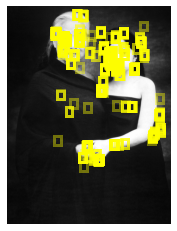

In [28]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
for i, j in indices[labels == 1]:            
    ax.add_patch(plt.Rectangle((j, i), 
                               Nj, Ni, 
                               edgecolor='yellow',                                       
                              alpha=0.4, lw=3,                                       
                              facecolor='none'))
plt.show()